# Synopsis

# Configuration

In [1]:
slug = 'persuasion'
db_file = 'persuasion.db'
# vocab_weight = 'tfidf_sum'
vocab_weight = 'tf_sum'
vocab_weight_quantile = .94
vocab_min_n = 3
kde_kernel = 'gaussian'
kde_bandwidth = 2000
kde_samples = 1000

# Libraries

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.neighbors import KernelDensity as KDE

# Pragmas

In [3]:
from IPython.display import display, HTML

In [4]:
%matplotlib inline
%pwd

'/Users/rca2t/Dropbox/Courses/DSI/DS5559/MAIN_REPO/labs/2019-02-21_Lab06'

# Functions

In [5]:
def get_term_id(vocab, term_str):
    return vocab[vocab.term_str == term_str].index[0]

def get_term_str(vocab, term_id):
    return vocab.loc[term_id].term_str

# Process

## Import tables from database

In [6]:
with sqlite3.connect(db_file) as db:
    V = pd.read_sql("SELECT * FROM vocab WHERE stop = 0", db, index_col='term_id')
    K = pd.read_sql("SELECT term_id, term_str FROM token WHERE term_id >= 0", db)

## Prepare Tokens index

We don't have to flatten the index since we just grabbed one column from the table.

In [7]:
K.rename_axis('offset', inplace=True)

In [8]:
K.head(11).T

offset,0,1,2,3,4,5,6,7,8,9,10
term_id,800,4658,5534,1635,3442,2854,2342,2605,4734,5548,0
term_str,chapter,sir,walter,elliot,of,kellynch,hall,in,somersetshire,was,a


## Filter Vocab

In [9]:
V1 = V[(V[vocab_weight] > V[vocab_weight].quantile(vocab_weight_quantile)) & (V.n >= vocab_min_n)]

In [10]:
V1.shape[0]

334

In [11]:
V1.sort_values(vocab_weight, ascending=False).head(10).T

term_id,240,733,1635,3273,2891,3272,5586,4393,2245,3013
term_str,anne,captain,elliot,mrs,lady,mr,wentworth,russell,good,little
n,497,303,289,291,216,256,218,148,187,176
p,0.0059057,0.00360046,0.0034341,0.00345786,0.00256666,0.00304197,0.00259043,0.00175864,0.00222206,0.00209135
port_stem,ann,captain,elliot,mr,ladi,mr,wentworth,russel,good,littl
stop,0,0,0,0,0,0,0,0,0,0
df,24,17,22,24,23,24,18,20,24,24
tf_sum,0.355982,0.21212,0.192902,0.188296,0.186791,0.168018,0.163166,0.13778,0.13749,0.130902
tf_mean,0.0148326,0.00883835,0.0080376,0.00784565,0.00778294,0.00700073,0.00679859,0.00574085,0.00572875,0.00545427
tf_max,0.0217677,0.0317091,0.0273722,0.0175182,0.0206083,0.0233576,0.0256182,0.0206083,0.0119521,0.0106007
tfidf_sum,0,0.10553,0.0242152,0,0.011469,0,0.06772,0.036241,0,0


## Get list of top terms

We'll use this later.

In [12]:
TOP_TERMS = V.sort_values(vocab_weight, ascending=False).term_str.head(30).tolist()

In [13]:
TOP_TERMS

['anne',
 'captain',
 'elliot',
 'mrs',
 'lady',
 'mr',
 'wentworth',
 'russell',
 'good',
 'little',
 'sir',
 'walter',
 'charles',
 'said',
 'time',
 'nothing',
 'man',
 'think',
 'great',
 'mary',
 'soon',
 'see',
 'miss',
 'musgrove',
 'father',
 'quite',
 'know',
 'louisa',
 'house',
 'bath']

## Filter Tokens by Vocab

In [14]:
K = K[K.term_id.isin(V1.index)]

In [15]:
K.head(11).T

offset,0,1,2,3,5,6,11,27,32,73,81
term_id,800,4658,5534,1635,2854,2342,3086,2110,2508,5279,2913
term_str,chapter,sir,walter,elliot,kellynch,hall,man,found,hour,turned,last


## Create arrays of offsets for each term

In [16]:
B = K.reset_index().groupby(['term_str']).offset.apply(lambda x: x.tolist()).to_frame()

In [17]:
B['x'] = B.apply(lambda x: np.array(x.offset)[:, np.newaxis], 1)

In [18]:
B.head()

,offset,x
term_str,,
able,"[2473, 3107, 11326, 12062, 13976, 15023, 16918...","[[2473], [3107], [11326], [12062], [13976], [1..."
account,"[6348, 11257, 11498, 11621, 11674, 12141, 1672...","[[6348], [11257], [11498], [11621], [11674], [..."
acquaintance,"[678, 1205, 1619, 1877, 2897, 8235, 9265, 1251...","[[678], [1205], [1619], [1877], [2897], [8235]..."
acquainted,"[6886, 7607, 7610, 10362, 15263, 18205, 20297,...","[[6886], [7607], [7610], [10362], [15263], [18..."
added,"[2147, 2398, 4765, 6396, 7990, 15299, 15644, 2...","[[2147], [2398], [4765], [6396], [7990], [1529..."


## Get KDE for each term

In [19]:
scale_max = K.index.max() # THIS IS CRUCIAL
x_axis = np.linspace(0, scale_max, kde_samples)[:, np.newaxis]
B['kde'] = B.apply(lambda row: KDE(kernel=kde_kernel, bandwidth=kde_bandwidth).fit(row.x), 1)
B['scores'] = B.apply(lambda row: row.kde.score_samples(x_axis), axis=1)
# B['scaled'] = B.apply(lambda row: np.exp(row.scores) * (scale_max / kde_samples), axis=1)

## Visualize KDE plots

In [20]:
PLOTS = B.apply(lambda row: pd.Series(np.exp(row.scores) * (scale_max / kde_samples)), axis=1)

In [21]:
FIG = dict(figsize=(15, 5))

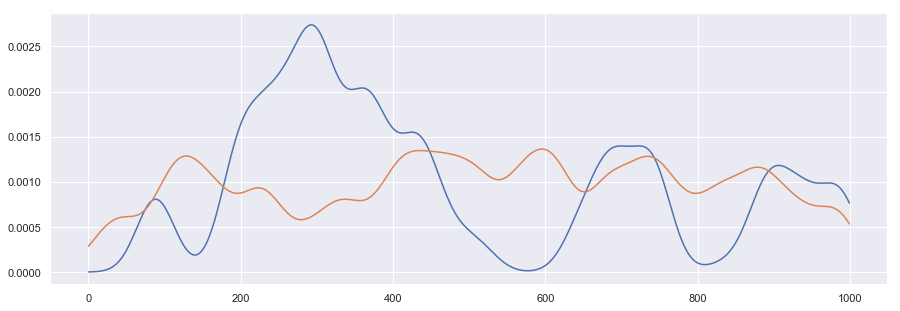

In [22]:
PLOTS.loc['wentworth'].plot(**FIG)
PLOTS.loc['anne'].plot(**FIG)

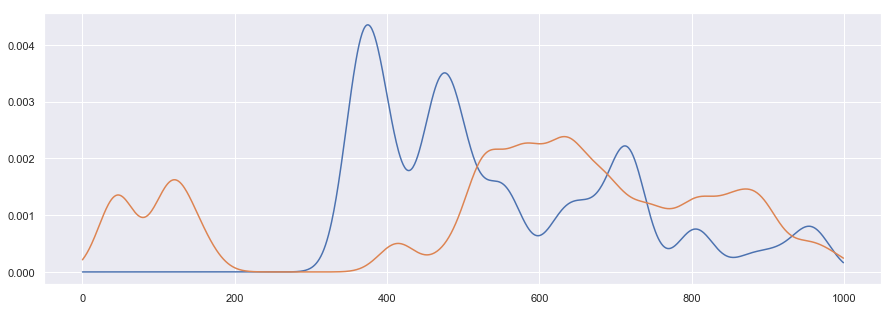

In [23]:
PLOTS.loc['lyme'].plot(**FIG)
PLOTS.loc['bath'].plot(**FIG)

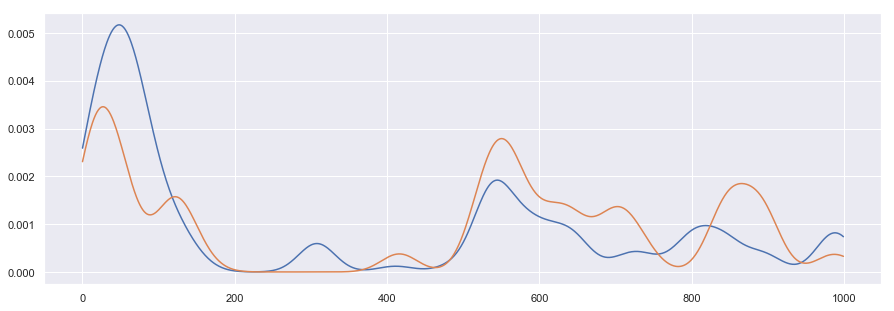

In [24]:
PLOTS.loc['walter'].plot(**FIG)
PLOTS.loc['elizabeth'].plot(**FIG)

## Score Pairs

We generate only unique combinations of pairs not permutation, i.e. we treat `a,b == b,a`.

In [25]:
pairs = pd.DataFrame([(x,y) for x in B.index for y in B.index if y > x] , columns=['x','y'])

In [26]:
pairs.head(10).T

,0,1,2,3,4,5,6,7,8,9
x,able,able,able,able,able,able,able,able,able,able
y,account,acquaintance,acquainted,added,admiral,advantage,afterwards,agreeable,alone,already


## Compute overlap

This takes a while to run.

In [27]:
def overlap(row):
    kde1 = PLOTS.loc[row.x]
    kde2 = PLOTS.loc[row.y]
    overlap = np.minimum(kde1, kde2)
    return np.trapz(overlap)

In [28]:
pairs['overlap'] = pairs.apply(overlap, axis=1)

In [29]:
def paircorr(row):
    return PLOTS.T[[row.x,row.y]].corr().values[0][1]

In [30]:
pairs['corr'] = pairs.apply(paircorr, axis=1)

## Skim Top Pairs

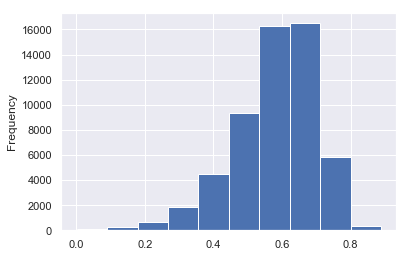

In [31]:
pairs.overlap.plot.hist()

In [32]:
pairs[pairs.overlap > .6 ].sort_values('overlap', ascending=False)

,x,y,overlap,corr
3892,anne,time,0.888853,0.664992
53225,soon,thought,0.883898,0.694970
3888,anne,think,0.882271,0.580125
3836,anne,said,0.873330,0.468276
52815,sir,walter,0.868082,0.986774
30961,give,perfectly,0.864782,0.601086
47642,others,said,0.859712,0.551964
31521,going,gone,0.856336,0.728878
10085,better,sister,0.856305,0.613802
36038,home,soon,0.856279,0.511203


In [33]:
pairs2 = pairs.copy().rename(columns={'x':'y', 'y':'x'})
pairs3 = pd.concat([pairs, pairs2], sort=True)

## See related terms for top terms

In [34]:
DETAIL = '<table>'
for i, term in enumerate(TOP_TERMS):
    friends = pairs3[pairs3.x == term].sort_values('overlap', ascending=False).head(10)
    DETAIL += "<tr><td colspan=1><b>{}. {}</b></td></tr>".format(i+1, term)
    for row in friends.reset_index(drop=True)[['y', 'overlap']].values:
        bar = round(row[1] * 100) * '|'
        DETAIL += "<tr><td>{}</td><td style='text-align:left;'>{} ({})</td></tr>".format(row[0], bar, row[1])
DETAIL += "</table>"

In [35]:
display(HTML(DETAIL))

## Explore term correlations

In [36]:
CORR = pd.crosstab(pairs3.x, pairs3.y, pairs3.overlap, aggfunc='sum').fillna(1)

In [37]:
CORR.head()

y,able,account,acquaintance,acquainted,added,admiral,advantage,afterwards,agreeable,alone,...,woman,women,word,world,worse,worth,year,years,yes,young
x,,,,,,,,,,,,,,,,,,,,,
able,1.000000,0.723361,0.663163,0.592815,0.548700,0.397685,0.661511,0.661594,0.713752,0.530769,...,0.568169,0.407069,0.698261,0.581498,0.664767,0.456142,0.387226,0.568955,0.608786,0.636303
account,0.723361,1.000000,0.636510,0.613859,0.606703,0.427891,0.676947,0.652555,0.639395,0.563799,...,0.602763,0.404755,0.696417,0.603607,0.602471,0.507470,0.441465,0.613850,0.691491,0.690115
acquaintance,0.663163,0.636510,1.000000,0.635592,0.550674,0.422117,0.451457,0.532628,0.726128,0.491300,...,0.666979,0.477759,0.628689,0.654533,0.584594,0.641184,0.405960,0.629674,0.614287,0.543257
acquainted,0.592815,0.613859,0.635592,1.000000,0.622342,0.418056,0.524110,0.538164,0.653214,0.510965,...,0.585729,0.363088,0.621307,0.639275,0.527207,0.529139,0.404065,0.618066,0.619509,0.589142
added,0.548700,0.606703,0.550674,0.622342,1.000000,0.419163,0.597542,0.609216,0.582213,0.528287,...,0.675209,0.430922,0.637049,0.665079,0.560954,0.537281,0.563854,0.738564,0.566591,0.619979


In [38]:
def corr_plot_terms(terms, dtm, title='Foo'):
    plt.figure(figsize = (20,20))
    print(title)
    corr = dtm[terms].corr()
    sns.heatmap(corr, vmax=.3, annot=True, center=0, 
              cmap='RdYlGn',
              square=True, linewidths=.5, 
              cbar_kws={"shrink": .5})
    plt.show()

TEST


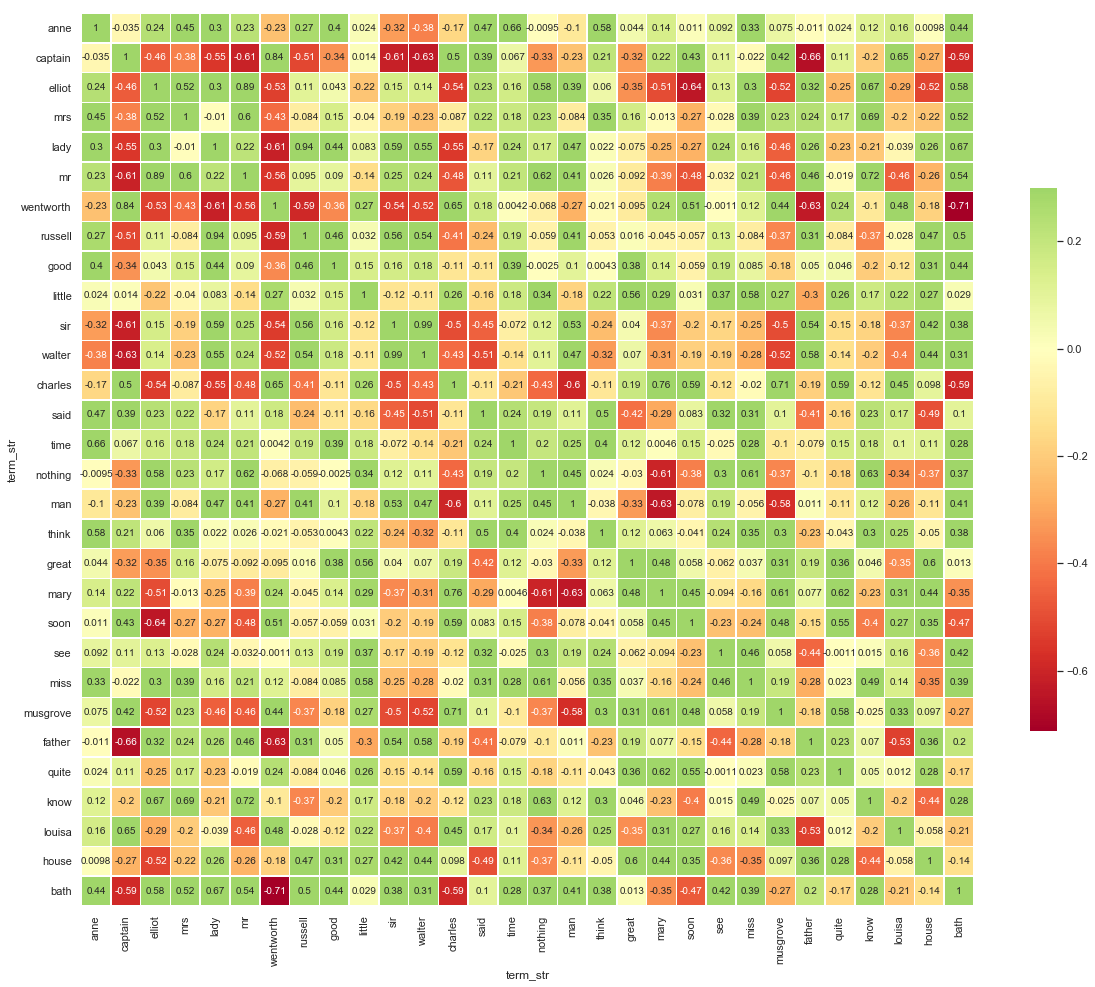

In [39]:
corr_plot_terms(TOP_TERMS, PLOTS.T, title='TEST')

## Export Graphs

In [40]:
import networkx as nx
G = nx.Graph()
edges = pairs[['x','y','overlap']].sort_values('overlap', ascending=False).head(1000).apply(lambda x: (x.x, x.y, x.overlap), axis=1).values
G.add_weighted_edges_from(edges)
nx.write_gexf(G, "{}.gexf".format(slug))

# Save

In [41]:
with sqlite3.connect(db_file) as db:
    pairs.to_sql('term_pair', db, if_exists='replace', index=True)
    PLOTS.T.to_sql('term_kde', db, if_exists='replace', index=True)
#     vocab.to_sql('vocab', db, if_exists='replace', index=True)

In [42]:
# END